In [19]:
#IMPORTS

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image


In [20]:
print(os.listdir("./data/"))

['.DS_Store', 'test', 'train']


In [21]:
#LOADING DATA
folder_benign_train = './data/train/benign'
folder_malignant_train = './data/train/malignant'

folder_benign_test = './data/test/benign'
folder_malignant_test = './data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

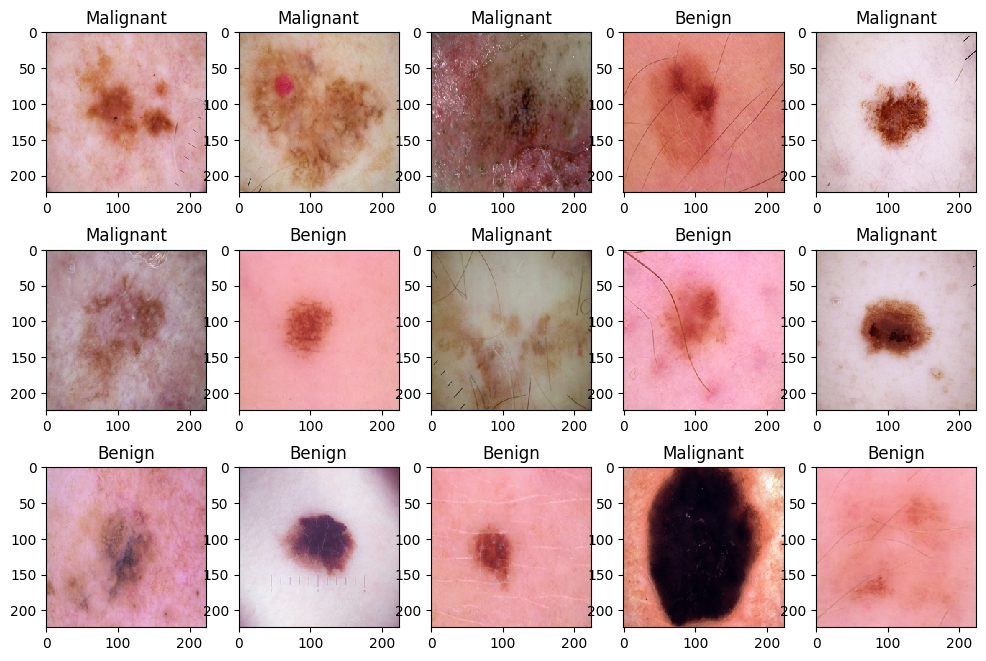

In [22]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

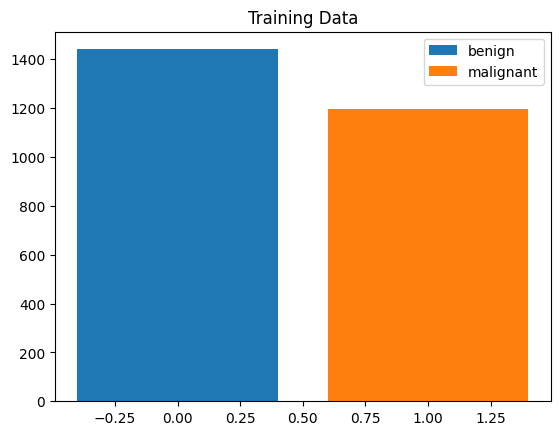

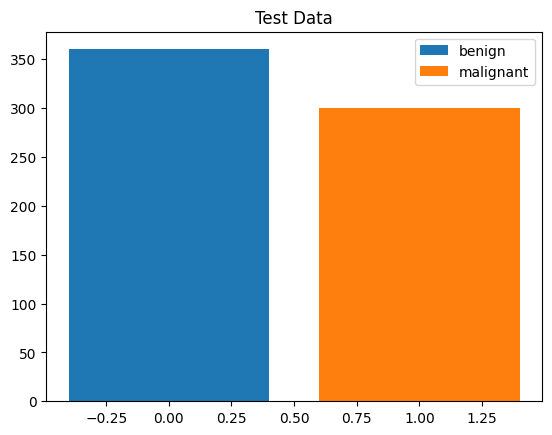

In [23]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()

In [24]:
import numpy as np

def normalize_images(images):
    images = images.astype('float32')
    images /= 255.0  # Scale pixel values to [0, 1]
    return images

X_train = normalize_images(X_train)
X_test = normalize_images(X_test)

In [25]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

model_vgg16 = VGG16(weights='imagenet', include_top=False)
feature_extractor = Model(inputs=model_vgg16.inputs, outputs=model_vgg16.layers[-2].output)

def extract_features(sample):
    features = feature_extractor.predict(sample)
    return features

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

21/21 [==============================] - 40s 2s/step


In [26]:
# Reshape the image data into 2D arrays
# Assuming 'X_train_features' and 'X_test_features' are your image datasets
# and each image originally has the shape (224, 224, 3) or similar

# Reshape the training data
num_training_samples = X_train_features.shape[0]
X_train_reshaped = X_train_features.reshape(num_training_samples, -1)

# Reshape the testing data
num_testing_samples = X_test_features.shape[0]
X_test_reshaped = X_test_features.reshape(num_testing_samples, -1)

# Now, apply PCA on the reshaped data
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)  # retain 90% of the variance
X_train_pca = pca.fit_transform(X_train_reshaped)
X_test_pca = pca.transform(X_test_reshaped)


In [27]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_pca, y_train)

SVC()

In [28]:

from sklearn.metrics import accuracy_score, classification_report

y_pred = svm_model.predict(X_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8575757575757575
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87       360
         1.0       0.83      0.86      0.85       300

    accuracy                           0.86       660
   macro avg       0.86      0.86      0.86       660
weighted avg       0.86      0.86      0.86       660



In [29]:

from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_train_pca, y_train, cv=5)
print("Cross-validation scores:", scores)

Cross-validation scores: [0.83712121 0.85037879 0.86717268 0.83870968 0.85958254]
